# Tutorial: getting started with Delight

- author : Sylvie Dagoret-Campagne
- date : March 18th 2021
- affiliation : IJCLab/IN2P3/CNRS

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [28]:
import sys
from mpi4py import MPI
import numpy as np
from scipy.interpolate import interp1d
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel
import scipy.stats
import matplotlib.pyplot as plt
import emcee
import corner

# Create a logger object.
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s %(name)s[%(process)d] %(levelname)s %(message)s')

from matplotlib.colors import LogNorm

comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()

In [2]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [3]:
from pkg_resources import resource_filename

# Configuration

## Simulation data

In [4]:
configsimfilename="tmpsim/parametersTest.cfg"

In [5]:
paramssim = parseParamFile(configsimfilename, verbose=True)

2021-05-17 15:46:20,981 ipykernel_launcher.py, delight.io[58] WARNING Input parameter file:tmpsim/parametersTest.cfg
2021-05-17 15:46:20,983 ipykernel_launcher.py, delight.io[58] WARNING Parameters read:


>  rootDir              ./
>  bands_directory      ./tmpsim/delight_indata/FILTERS
>  bandNames            lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
>  numCoefs             15
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      False
>  templates_directory  ./tmpsim/delight_indata/CWW_SEDs
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  templates_verbose    False
>  templates_debug      False
>  training_numChunks   1
>  training_paramFile   ./tmpsim/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmpsim/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand lsst_i
>  training_bandOrder   lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var lsst_i lsst_i_var lsst_z lsst_z_var lsst_y ls

### DESC Delight data

In [6]:
configdatafilename="tmpsim/parametersTest.cfg"

In [7]:
paramsdata = parseParamFile(configdatafilename, verbose=True)

2021-05-17 15:46:21,027 ipykernel_launcher.py, delight.io[58] WARNING Input parameter file:tmpsim/parametersTest.cfg
2021-05-17 15:46:21,029 ipykernel_launcher.py, delight.io[58] WARNING Parameters read:


>  rootDir              ./
>  bands_directory      ./tmpsim/delight_indata/FILTERS
>  bandNames            lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
>  numCoefs             15
>  bands_verbose        True
>  bands_debug          True
>  bands_makeplots      False
>  templates_directory  ./tmpsim/delight_indata/CWW_SEDs
>  lambdaRef            4500.0
>  templates_names      El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
>  p_t                  [0.27   0.26   0.25   0.069  0.021  0.11   0.0061 0.0079]
>  p_z_t                [0.23 0.39 0.33 0.31 1.1  0.34 1.2  0.14]
>  templates_verbose    False
>  templates_debug      False
>  training_numChunks   1
>  training_paramFile   ./tmpsim/delight_data/galaxies-gpparams.txt
>  training_catFile     ./tmpsim/delight_data/galaxies-fluxredshifts.txt
>  training_referenceBand lsst_i
>  training_bandOrder   lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var lsst_i lsst_i_var lsst_z lsst_z_var lsst_y ls

# Analyse

In [8]:
params=paramsdata

In [9]:
DL = approx_DL()
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

In [10]:

bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
dir_filters = params['bands_directory']
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')


## Analyze the outputs

In [11]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

404 740 31 719 545 904 935 970 617 688 315 589 569 122 588 681 297 892 498 824 

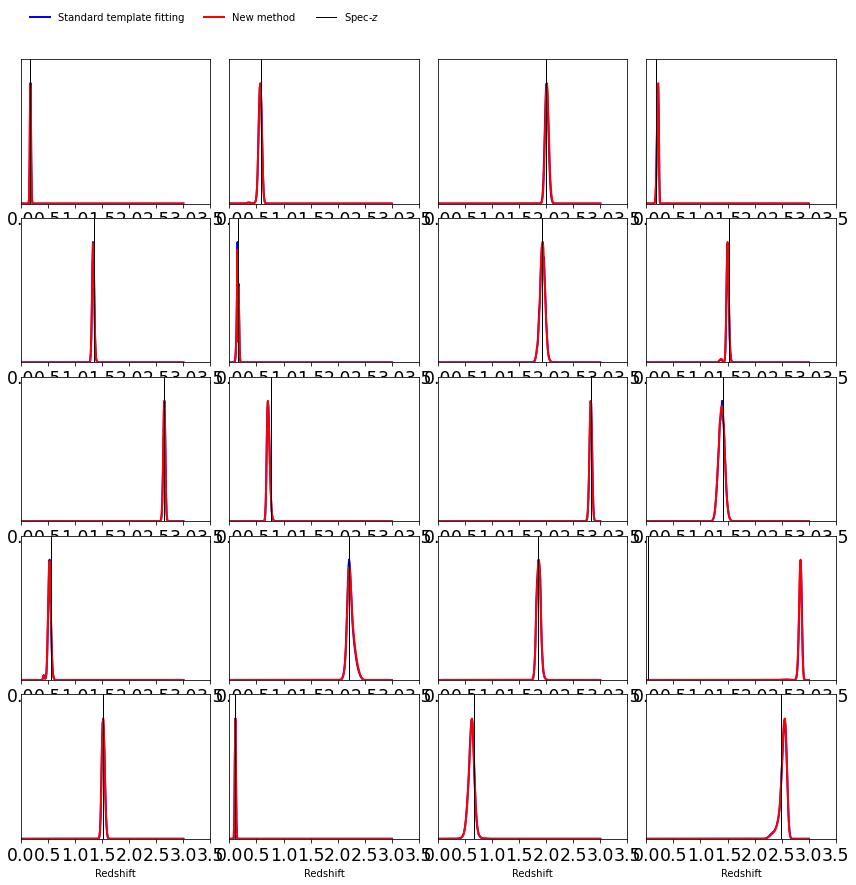

In [12]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(12, 12), sharex=False, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw,color='b' ,label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, color="r",label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 3.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


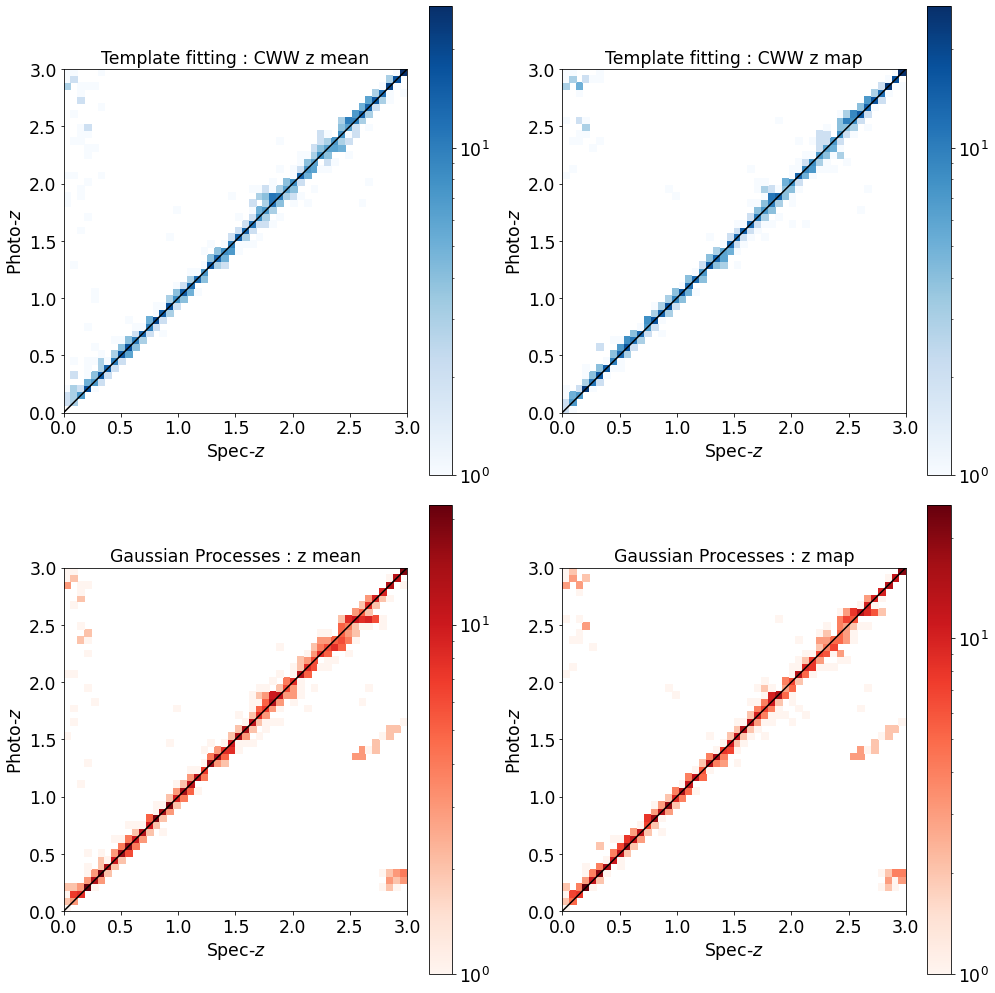

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
zmax = 3
rr = [[0, zmax], [0, zmax]]
nbins = 50
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Blues', range=rr,norm=LogNorm())
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('Template fitting : CWW z mean')
h2=axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Blues', range=rr, norm=LogNorm())
axs[0, 1].set_title('Template fitting : CWW z map')
h3=axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Reds', range=rr, norm=LogNorm())
axs[1, 0].set_title('Gaussian Processes : z mean')
h4=axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Reds', range=rr, norm=LogNorm())
axs[1, 1].set_title('Gaussian Processes : z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')



axs[0,0].set_xlabel('Spec-$z$')
axs[0,1].set_xlabel('Spec-$z$')
axs[1,0].set_xlabel('Spec-$z$')
axs[1,1].set_xlabel('Spec-$z$')

axs[0,0].set_ylabel('Photo-$z$')
axs[0,1].set_ylabel('Photo-$z$')
axs[1,0].set_ylabel('Photo-$z$')
axs[1,1].set_ylabel('Photo-$z$')

fig.colorbar(h[3], ax=axs[0,0])
fig.colorbar(h2[3], ax=axs[0,1])
fig.colorbar(h3[3], ax=axs[1,0])
fig.colorbar(h4[3], ax=axs[1,1])


axs[0,0].set_aspect('equal')
axs[1,0].set_aspect('equal')
axs[0,1].set_aspect('equal')
axs[1,1].set_aspect('equal')



fig.tight_layout()

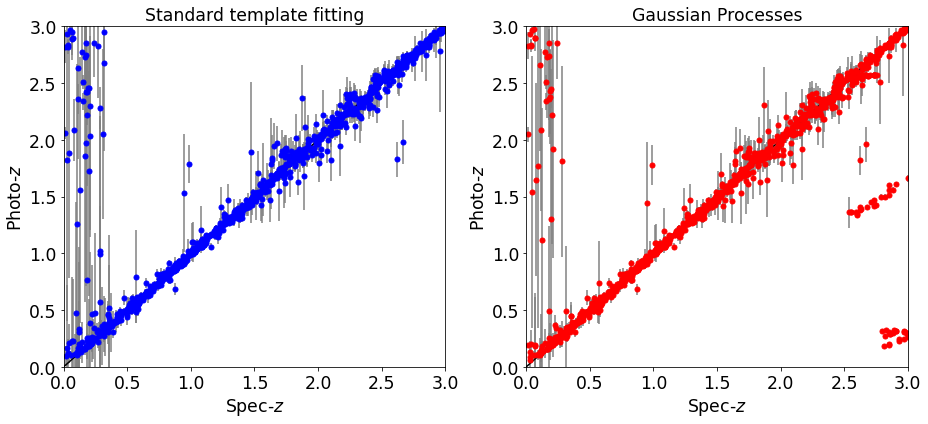

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[1].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, color="r",ecolor='grey',capsize=0)
axs[0].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o',color="b" ,markersize=5, ecolor='grey',capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[1].set_title('Gaussian Processes')
axs[0].set_title('Standard template fitting')

axs[0].set_xlabel('Spec-$z$')
axs[0].set_ylabel('Photo-$z$')
axs[1].set_xlabel('Spec-$z$')
axs[1].set_ylabel('Photo-$z$')

fig.tight_layout()

Text(0.5, 1.0, 'Gaussian Processes')

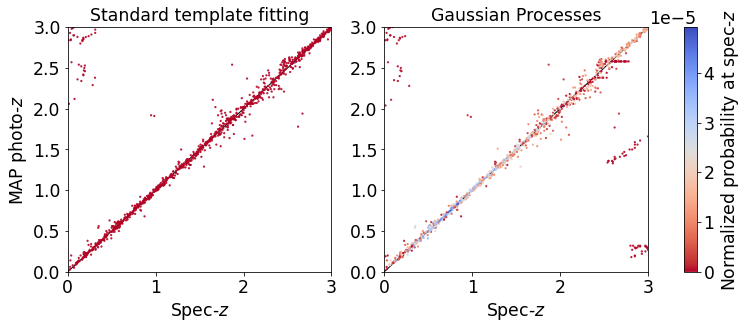

In [15]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(13, 4.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('Gaussian Processes')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.